In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, warnings
from natsort import natsorted
from natsort import humansorted
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from numpy.random import Generator, PCG64
rng_pg = Generator(PCG64())
from scipy.optimize import newton, minimize, fsolve
from scipy.optimize import nnls
import statsmodels.api as sm
import statsmodels.formula.api as smf


### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook")
%matplotlib inline

from wand.image import Image as WImage

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.curve_fitting import loss_func_c1, loss_func_l1, loss_func_l2, hl_bsl_fit, lin_fit_off, obj_lin_fit_off, bootstrap_hl, bootstrap_hl_fast

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting_pub'

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/charge_titration
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


# Charge titration to validate tRNA-charge sequencing approach

This notebook is a copy of `process_data.ipynb` for making plots more suitable for publication.
Explanatory text is largely omitted, see `process_data.ipynb` for details.

### Read and filter input data

In [3]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
sample_df['run_v1'] = np.array([fn[0:10] == '2022-12-28' for fn in sample_df['fastq_mate1_filename']])

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='ALL_stats_aggregate.csv', \
                     overwrite_dir=False)

# Add E.coli control RPM to sample level information:
ecoliLys_mask = (plot_obj.charge_filt['tr']['tRNA_anno_short'] == 'eColiLys-TTT-1-1')
ectr = plot_obj.charge_filt['tr'][ecoliLys_mask].copy()
sample_df = ectr.loc[:, ['sample_name_unique', 'RPM']].merge(sample_df, on='sample_name_unique')
sample_df = sample_df.rename(columns={'RPM': 'RPM_Ectr'}, errors='ignore')

# Extract dataframe with charge and add sample information:
charge_df = sample_df.loc[:, ['sample_name_unique', 'hue_value', \
                              'hue_order', 'RPM_Ectr', 'plot_group', \
                              'run_v1']].merge(plot_obj.charge_filt['tr'], on='sample_name_unique')
charge_df['tRNA_anno_short'] = ['mito-'+an if mc else an for an, mc in zip(charge_df['tRNA_anno_short'], charge_df['mito_codon'])]
charge_df['RPM_norm'] = charge_df['RPM'] / charge_df['RPM_Ectr']

# Convert percent charged to an integer value,
# and isolate the titration samples:
mask = (charge_df['plot_group'] == 'Charge-titration') & ~(charge_df['sample_name'] == '100p')
titr_df = charge_df[mask].copy()
frac_list = list()
for sn in titr_df['sample_name']:
    try:
        frac_list.append(int(sn[0:3]))
        continue
    except:
        pass
    try:
        frac_list.append(int(sn[0:2]))
        continue
    except:
        pass
    try:
        frac_list.append(int(sn[0:1]))
        continue
    except:
        raise Exception('???')
titr_df['percent_charged'] = frac_list
charge_df['percent_charged'] = None
charge_df.loc[mask, 'percent_charged'] = frac_list

Folder exists and overwrite set to false... Doing nothing.


In [4]:
# Enforce minimum UMI count:
min_count = 700
# For each tRNA annotation, find samples
# that have above the minimum count:
tann2snu = dict()
for snu, tann, ectr, cnt in zip(titr_df['sample_name_unique'], \
                                titr_df['tRNA_annotation'], \
                                titr_df['Ecoli_ctr'], \
                                titr_df['UMIcount']):
    if ectr or cnt <= min_count:
        continue
    
    if tann in tann2snu:
        tann2snu[tann].add(snu)
    else:
        tann2snu[tann] = set()
        tann2snu[tann].add(snu)

# Filter tRNA annotation based on
# all samples having above the minimum count:
all_snu = set(titr_df['sample_name_unique'])
tann_sele = set()
for tann in tann2snu:
    if tann2snu[tann] == all_snu:
        tann_sele.add(tann)
mask = (titr_df['tRNA_annotation'].isin(tann_sele))
titr_df = titr_df[mask].copy()

### Analysis of control samples

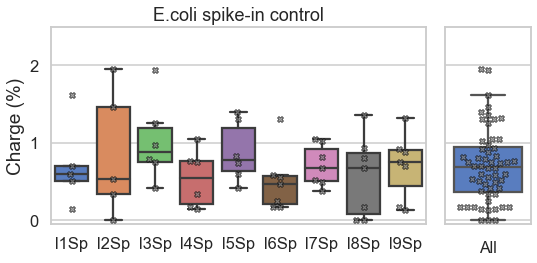

In [5]:
# Select E.coli controls samples:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(1, 2, width_ratios=[4.4, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    
    ectr_mask = (charge_df['tRNA_anno_short'] == 'eColiLys-TTT-1-1') & \
                ~(charge_df['sample_name'] == '100p') & \
                (charge_df['plot_group'] == 'Charge-titration')

    # Plot charge split on percentage intact tRNA:
    g1 = sns.boxplot(ax=ax1, data=charge_df[ectr_mask], x='barcode', y='charge', \
                     fliersize=False, order=sorted(set(charge_df['barcode'])))
    g1 = sns.swarmplot(ax=ax1, data=charge_df[ectr_mask], x='barcode', y='charge', \
                       color='grey', alpha=0.7, edgecolor='black', dodge=True, \
                       linewidth=0.8, size=6, marker='X', warn_thresh=1, \
                       order=sorted(set(charge_df['barcode'])))

    g1.set(ylim=(-0.05, 2.5))
    g1.set_ylabel('Charge (%)', size=19)
    g1.set_xlabel('')
    g1.set_title('E.coli spike-in control')

    
    # Plot for all samples:
    g2 = sns.boxplot(ax=ax2, data=charge_df[ectr_mask], y='charge', \
                     fliersize=False)
    g2 = sns.swarmplot(ax=ax2, data=charge_df[ectr_mask], y='charge', \
                       color='grey', alpha=0.7, edgecolor='black', dodge=True, \
                       linewidth=0.8, size=6, marker='X', warn_thresh=1)
    g2.set(ylabel='', xlabel='All samples')
    g2.set_xlabel('All', size=16)
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    fig.tight_layout()
    fig.savefig('data/plotting_pub/ecoli-control_charge.pdf', bbox_inches='tight')

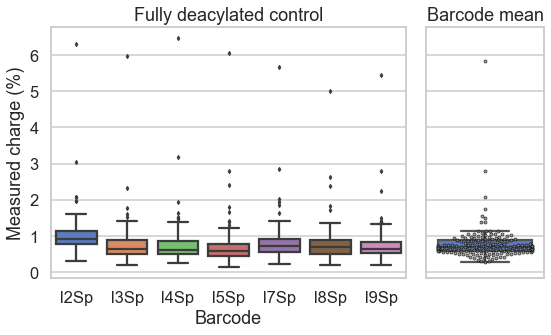

In [6]:
# Plot the charge of the
# fully deacylated samples:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(8, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    
    # Find the mean/max charge for the two types 
    # of fully deacylated samples:
    zerom = (charge_df['sample_name'] == '0p') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 1000)
    zero_df = charge_df[zerom].groupby('tRNA_annotation').agg(charge_mean=('charge', 'mean'), \
                                                              charge_max=('charge', 'max')).reset_index()
    zerom_90m = (charge_df['sample_name'] == '0p_90m') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 1000)
    zero_df_90m = charge_df[zerom_90m].groupby('tRNA_annotation').agg(charge_mean=('charge', 'mean'), \
                                                                      charge_max=('charge', 'max')).reset_index()

    # Plot charge split on barcodes:
    bc_order = natsorted(set(charge_df.loc[zerom, 'barcode']))
    g1 = sns.boxplot(ax=ax1, data=charge_df[zerom], x='barcode', y='charge', \
                     fliersize=3, order=bc_order)
#    g1 = sns.swarmplot(ax=ax1, data=charge_df[zerom], x='barcode', y='charge', \
#                       color='grey', alpha=0.7, edgecolor='black', dodge=True, \
#                       linewidth=0.8, size=2, warn_thresh=1, \
#                       order=bc_order)
    g1.set(ylabel='Measured charge (%)', xlabel='Barcode')
    g1.set_title('Fully deacylated control')

    # Plot barcode average:
    g2 = sns.boxplot(ax=ax2, y=zero_df['charge_mean'].values, fliersize=False)
    g2 = sns.swarmplot(ax=ax2, y=zero_df['charge_mean'].values, \
                       color='grey', alpha=0.7, edgecolor='black', \
                       linewidth=0.8, size=3, warn_thresh=1)
    g2.set_title('Barcode mean')
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    fig.tight_layout()
    fig.savefig('data/plotting_pub/deacylated-control_charge.pdf', bbox_inches='tight')

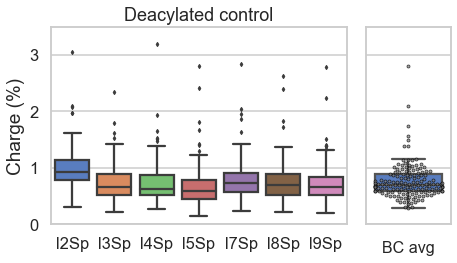

In [7]:
# Plot the charge of the
# fully deacylated samples without the fMet:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6.7, 4))
    gs = fig.add_gridspec(1, 2, width_ratios=[3.5, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    
    # Find the mean/max charge for the two types 
    # of fully deacylated samples:
    fMet_mask = (charge_df['sample_name'] == '0p') & \
                (~charge_df['Ecoli_ctr']) & \
                (charge_df['RPM'] > 1000) & \
                (charge_df['tRNA_anno_short'] != 'mito-Met-CAT')
    zero_df_fMet = charge_df[fMet_mask].groupby('tRNA_annotation').agg(charge_mean=('charge', 'mean'), \
                                                                       charge_max=('charge', 'max')).reset_index()
    # Plot charge split on barcodes:
    bc_order = natsorted(set(charge_df.loc[fMet_mask, 'barcode']))
    g1 = sns.boxplot(ax=ax1, data=charge_df[fMet_mask], x='barcode', y='charge', \
                     fliersize=3, order=bc_order)
#    g1 = sns.swarmplot(ax=ax1, data=charge_df[zerom], x='barcode', y='charge', \
#                       color='grey', alpha=0.7, edgecolor='black', dodge=True, \
#                       linewidth=0.8, size=2, warn_thresh=1, \
#                       order=bc_order)
    g1.set(ylim=(0, 3.5))
    g1.set_ylabel('Charge (%)', size=19)
    g1.set_xlabel('')
    g1.set_title('Deacylated control')

    # Plot barcode average:
    g2 = sns.boxplot(ax=ax2, y=zero_df_fMet['charge_mean'].values, fliersize=False)
    g2 = sns.swarmplot(ax=ax2, y=zero_df_fMet['charge_mean'].values, \
                       color='grey', alpha=0.7, edgecolor='black', \
                       linewidth=0.8, size=3, warn_thresh=1)
    g2.set_xlabel('BC avg', size=16)
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    fig.tight_layout()
    fig.savefig('data/plotting_pub/deacylated-control_charge_nofMet.pdf', bbox_inches='tight')

In [8]:
# Load previously calculated half-lifes.
# Not with fMet included, as this is a two-species model.
hl_df = pd.read_csv('../charge_half-life/acylation_half-lifes_features.csv')
hl_df = hl_df.merge(zero_df, on='tRNA_annotation')
hl_df['discr_base_C'] = (hl_df['discr_base'] == 'C')
hl_df['fs_GG'] = (hl_df['first_base'] == 'G') & (hl_df['second_base'] == 'G')
hl_df['len_long'] = (hl_df['tRNA_annotation_len'] > 84)
hl_df['len_mid'] = (hl_df['tRNA_annotation_len'] < 84) & (hl_df['tRNA_annotation_len'] > 73)
hl_df['len_short'] = (hl_df['tRNA_annotation_len'] <= 73)

In [9]:
# Run OLS:
results = smf.ols('np.log2(charge_mean) ~ fs_GG + len_long + len_mid + len_short + np.divide(-1, hl) + discr_base_C + mito_codon', data=hl_df).fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     np.log2(charge_mean)   R-squared:                       0.606
Model:                              OLS   Adj. R-squared:                  0.590
Method:                   Least Squares   F-statistic:                     36.21
Date:                  Mon, 26 Jun 2023   Prob (F-statistic):           2.73e-26
Time:                          16:14:38   Log-Likelihood:                -40.219
No. Observations:                   148   AIC:                             94.44
Df Residuals:                       141   BIC:                             115.4
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   

In [10]:
# Run OLS with only significant features:
results = smf.ols('np.log2(charge_mean) ~ np.divide(1, hl) + discr_base_C + mito_codon + len_long', data=hl_df).fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     np.log2(charge_mean)   R-squared:                       0.606
Model:                              OLS   Adj. R-squared:                  0.595
Method:                   Least Squares   F-statistic:                     55.04
Date:                  Mon, 26 Jun 2023   Prob (F-statistic):           5.08e-28
Time:                          16:14:38   Log-Likelihood:                -40.256
No. Observations:                   148   AIC:                             90.51
Df Residuals:                       143   BIC:                             105.5
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   

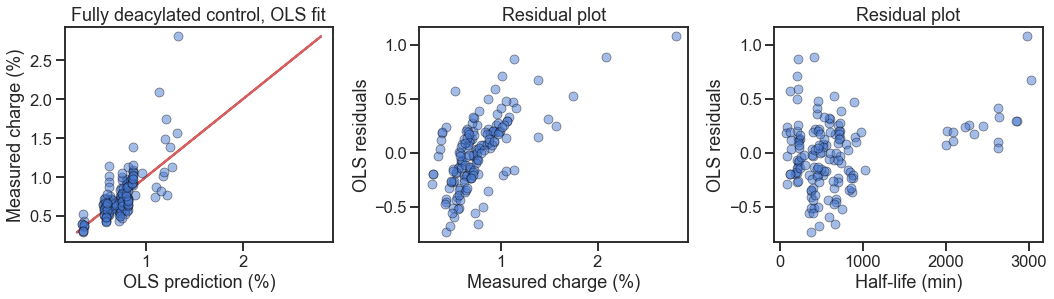

In [11]:
# Plot OLS fit and diagnostics:
fig = plt.figure(figsize=(15, 4.5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

charge_mean_pred = 2**results.predict()

# OLS fit:
g1 = sns.scatterplot(ax=ax1, x=charge_mean_pred, y=hl_df['charge_mean'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g1.set_title('Fully deacylated control, OLS fit')
g1.set(xlabel='OLS prediction (%)', ylabel='Measured charge (%)')
ax1.plot(hl_df['charge_mean'], hl_df['charge_mean'], c='r', zorder=1)

# OLS residuals:
g2 = sns.scatterplot(ax=ax2, y=results.resid, x=hl_df['charge_mean'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g2.set_title('Residual plot')
g2.set(ylabel='OLS residuals', xlabel='Measured charge (%)')

# OLS residuals vs half-life:
g3 = sns.scatterplot(ax=ax3, y=results.resid, x=hl_df['hl'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g3.set_title('Residual plot')
g3.set(ylabel='OLS residuals', xlabel='Half-life (min)')

fig.tight_layout()

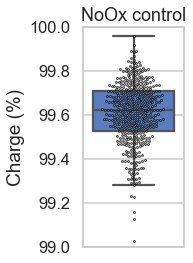

In [12]:
# Plot the charge for the
# non-oxidized control samples:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(3, 4))
    noxm = (charge_df['sample_name'] == '40h_NoOx') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 2000)
    g1 = sns.boxplot(ax=ax1, y=charge_df.loc[noxm, 'charge'].values, fliersize=False)
    g1 = sns.swarmplot(ax=ax1, y=charge_df.loc[noxm, 'charge'].values, \
                       color='grey', alpha=0.7, edgecolor='black', \
                       linewidth=0.8, size=2)
    g1.set(ylim=(99, 100))
    g1.set_ylabel('Charge (%)', size=19)
    g1.set_title('NoOx control')
    fig.tight_layout()
    fig.savefig('data/plotting_pub/NoOx-control_charge.pdf', bbox_inches='tight')

In [13]:
# Run OLS to predict the "missing" charge
# in the non-oxidized controls:
noxm = (charge_df['sample_name'] == '40h_NoOx') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 1000)
in_df = charge_df[noxm].groupby(['tRNA_annotation']).agg(intact_charge=('charge', 'mean')).reset_index()
hl_df = hl_df.merge(in_df, on='tRNA_annotation', how='inner', copy=False, suffixes=(None, '_y'))
hl_df['degrad_charge'] = 100 - hl_df['intact_charge']
results = smf.ols('degrad_charge ~ fs_GG + len_long + len_mid + len_short + mito_codon + discr_base', data=hl_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          degrad_charge   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     12.59
Date:                Mon, 26 Jun 2023   Prob (F-statistic):           1.92e-12
Time:                        16:14:40   Log-Likelihood:                 145.04
No. Observations:                 147   AIC:                            -274.1
Df Residuals:                     139   BIC:                            -250.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2825      0

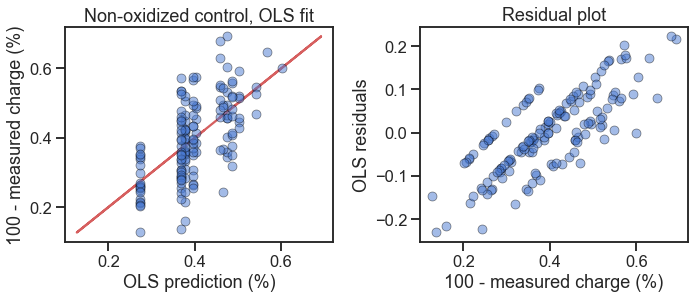

In [14]:
# Plot OLS fit and diagnostics:
fig = plt.figure(figsize=(10, 4.5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# OLS fit:
g1 = sns.scatterplot(ax=ax1, x=results.predict(), y=hl_df['degrad_charge'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g1.set_title('Non-oxidized control, OLS fit')
g1.set(xlabel='OLS prediction (%)', ylabel='100 - measured charge (%)')
ax1.plot(hl_df['degrad_charge'], hl_df['degrad_charge'], c='r', zorder=1)

# OLS residuals:
g2 = sns.scatterplot(ax=ax2, y=results.resid, x=hl_df['degrad_charge'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g2.set_title('Residual plot')
g2.set(ylabel='OLS residuals', xlabel='100 - measured charge (%)')

fig.tight_layout()

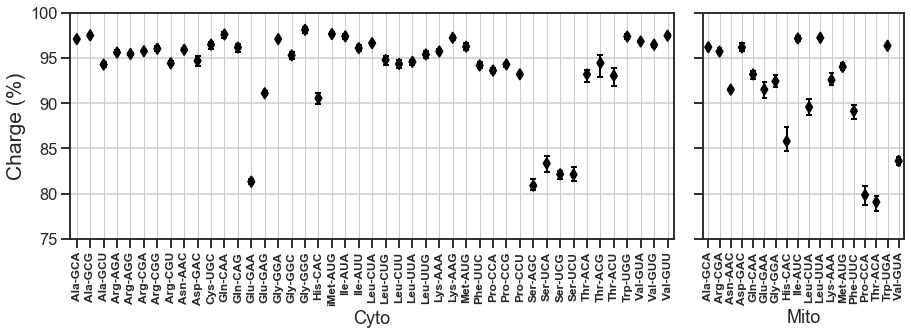

In [15]:
# Plot per codon charge:
with sns.axes_style("ticks", rc={'lines.solid_capstyle': 'projecting'}):
    fig = plt.figure(figsize=(13, 5))
    gs = fig.add_gridspec(1, 30)
    ax1 = fig.add_subplot(gs[0, 0:22])
    ax2 = fig.add_subplot(gs[0, 22:], sharey=ax1)

    # Plot for cyto:
    cyto_mask = (~charge_df['mito_codon']) & (~charge_df['Ecoli_ctr']) & (charge_df['sample_name'] == '100p_0m') & (charge_df['RPM'] > 1000)
    plot_df = charge_df[cyto_mask].groupby(['AA_codon', 'replicate']).agg(charge_mean=('charge', 'mean')).reset_index()

    g1 = sns.pointplot(ax=ax1, data=plot_df, x='AA_codon', y='charge_mean', \
                       join=False, errorbar=('ci', 95), capsize=0.3, scale=0.7, errwidth=2, \
                       color='black', markers='d', order=humansorted(set(plot_df['AA_codon'].values)))

    g1.set(xlabel='Cyto', ylim=(75, 100))
    g1.set_ylabel('Charge (%)', size=21)
    
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90, size=12, weight="bold")
    
    ax1.xaxis.grid(True, linewidth=1)
    ax1.yaxis.grid(True)

    # Plot for mito:
    mito_mask = (charge_df['mito_codon']) & (~charge_df['Ecoli_ctr']) & (charge_df['sample_name'] == '100p_0m') & (charge_df['RPM'] > 1000)
    plot_df = charge_df[mito_mask].groupby(['AA_codon', 'replicate']).agg(charge_mean=('charge', 'mean')).reset_index()
    g2 = sns.pointplot(ax=ax2, data=plot_df, x='AA_codon', y='charge_mean', \
                       join=False, errorbar=('ci', 95), capsize=0.3, scale=0.7, errwidth=2, \
                       color='black', markers='d', order=humansorted(set(plot_df['AA_codon'].values)))
    g2.set(xlabel='Mito', ylabel='')
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90, size=12, weight="bold")
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    ax2.xaxis.grid(True, linewidth=1)
    ax2.yaxis.grid(True)

    fig.tight_layout()
    fig.savefig('data/plotting_pub/baseline_codon_charge.pdf', bbox_inches='tight')

In [16]:
# Function to infer and calculate the concentration of deacylated
# compared to intact RNA (correction factor)
# including plotting of the results.
def infer_FB(df, tRNA_name, BFGS_loss_func=loss_func_l2, plot_return=True, plot_fh=None):
    # Extract information for the fit:
    x = df['percent_charged'].values # "p" above
    y = df['charge'].values          # The measured charge
    A_charge = y[x==100].mean()      # "TA_i" above
    B_charge = y[x==0].mean()        # "TB_i" above
    
    # Input realistic bounds (4x either direction)
    # and use no difference as initial guess:
    bnds = ((0.25, 4), )
    guess = (1, )
    # Do the minimization with BFGS:
    def fun_F(p): return(obj_F_fit(BFGS_loss_func, x, y, A_charge, B_charge, p))
    p_fun_FB = minimize(fun_F, guess, method='L-BFGS-B', bounds=bnds)
    FB_inferred = p_fun_FB.x[0]
    # Calculate the signed prediction error
    # this would be percentage point deviation:
    x_trans = x_trans_fun(x, A_charge, B_charge, FB_inferred)
    pred_err = y - x_trans
    df['pred_err'] = pred_err
    
    # "Calculate" the correction factor
    # using the e.coli spike-in normalized RPM values:
    ms = (x < 100) # drop 100p samples b/c e.coli control was added at different quantity
    y2 = df['RPM_norm'].values
    # Make a linear fit to use all data to better
    # predict normalized RPM:
    A = np.vstack([x[ms], np.ones(len(x[ms]))]).T
    slope, intersection = np.linalg.lstsq(A, y2[ms], rcond=None)[0]
    # Calculate the correction factor:
    rpm0_pred = intersection
    rpm100_pred = intersection + 100*slope
    FB_calculated = rpm0_pred/rpm100_pred
    

    ### Plotting ###
    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1.3, 1])
    
    # Predicted vs. measured using "inferred" correction factor:
    ax1 = fig.add_subplot(gs[0, 0])
    g1 = sns.scatterplot(ax=ax1, x=x_trans, y=y, zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g1.set_title('Factor inferred {:.2f}'.format(FB_inferred))
    g1.set(xlabel='Predicted charge (%)', ylabel='Measured charge (%)')
    ax1.plot(x, x, c='r', zorder=1)
    
    # Prediction error broken down by barcode:
    with sns.axes_style("whitegrid"):
        ax2 = fig.add_subplot(gs[0, 1])
        bc_order = sorted(set(df['barcode']))
        g2 = sns.boxplot(ax=ax2, data=df, x='barcode', y='pred_err', boxprops=dict(alpha=0.8), \
                         order=bc_order, fliersize=False, zorder=10)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.swarmplot(ax=ax2, data=df, x='barcode', y='pred_err', size=4, \
                      order=bc_order, color='white', alpha=0.8, edgecolor='black', \
                      linewidth=0.8, marker="X", zorder=11)
    g2.set_title('Barcode bias')
    g2.set(xlabel='Barcode', ylabel='Error (mes - pred; %)')

    # Normalized RPM data and linear fit to
    # generate the "calculated" correction factor:
    ax3 = fig.add_subplot(gs[0, 2])
    g3 = sns.scatterplot(ax=ax3, x=x[ms], y=y2[ms], zorder=11, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g3.set_title('Factor calculated {:.2f}'.format(FB_calculated))
    g3.set(xlabel='Intact tRNA in mix (%)', ylabel='RPM (norm. to spike-in)')
    y2_pred = intersection + slope*x
    ax3.plot(x, y2_pred, c='r', zorder=1)
    
    fig.suptitle('{}'.format(tRNA_name), size=17);
    fig.tight_layout()

    # Save plots:
    if not plot_fh is None:
        plot_fh.savefig(fig, bbox_inches='tight')
    else:
        fig.savefig('data/plotting_pub/{}.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)
    
    return((FB_inferred, FB_calculated), pred_err)


# Objective function for fitting the F_i variable:
def obj_F_fit(loss_func, x, y, A_charge, B_charge, p):
    F = p[0]
    x_trans = x_trans_fun(x, A_charge, B_charge, F)

    loss = sum(loss_func(y, x_trans))
    return(loss)

# Function to calculate the predicted charge:
def x_trans_fun(x, A_charge, B_charge, F):
    return((x*A_charge + (100-x)*F*B_charge) / (x + (100-x)*F))


In [17]:
# Run analysis on titration data
# one tRNA transcript at the time:
FB_res = list()
pred_list = list()
index_list = list()
anno_list = list(tann_sele)
with PdfPages('data/plotting_pub/titration-fit.pdf') as pp:
    for tann in anno_list:
        # Extract dataframe with single tRNA annotation:
        sample_mask = (titr_df['tRNA_annotation'] == tann)
        titr_spl = titr_df[sample_mask].copy()
        tann_short = titr_spl['tRNA_anno_short'].drop_duplicates().values[0]

        # Perform correction factor inference and plot:
        FB_tup, pred_err = infer_FB(titr_spl, tann_short, plot_fh=pp, plot_return=False)
        FB_res.append(FB_tup)
        pred_list.extend(pred_err)
        index_list.extend(titr_spl.index.values)

# Correction factor "inferred" and "calculated" to dataframe:
FB_df = pd.DataFrame(FB_res).rename(columns={0: 'Inferred', 1: 'Calculated'})
FB_df['tRNA_annotation'] = anno_list
FB_df = FB_df.merge(titr_df.loc[:, ['tRNA_annotation', 'tRNA_anno_short', 'tRNA_annotation_len', \
                                    'codon', 'anticodon', 'AA_codon', 'amino_acid', 'AA_letter', \
                                    'mito_codon', 'Ecoli_ctr']], \
                    on='tRNA_annotation').drop_duplicates().reset_index(drop=True)

# Prediction error to dataframe:
titr_df.loc[index_list, 'pred_err'] = pred_list

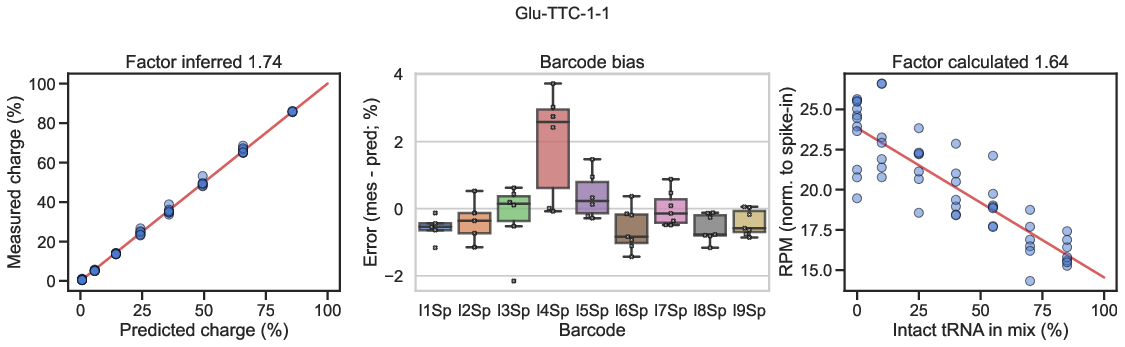

In [18]:
random_image = np.random.randint(len(anno_list))
img = WImage(filename='data/plotting_pub/titration-fit.pdf[{}]'.format(random_image))
img

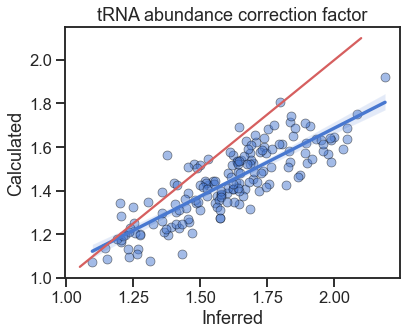

In [19]:
# Plot inferred vs. calculated correction factor:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

g1 = sns.regplot(ax=ax1, data=FB_df, x='Inferred', y='Calculated', \
                 scatter_kws=dict(alpha=0.5, edgecolor='black', linewidth=0.7))
g1.set(xlabel='Inferred', ylabel='Calculated')
g1.set_title('tRNA abundance correction factor')
ax1.plot([1.05, 2.1], [1.05, 2.1], c='r')
fig.tight_layout()
fig.savefig('data/plotting_pub/correction-factor.pdf', bbox_inches='tight')

In [20]:
FB_df.head(3)

,Inferred,Calculated,tRNA_annotation,tRNA_anno_short,tRNA_annotation_len,codon,anticodon,AA_codon,amino_acid,AA_letter,mito_codon,Ecoli_ctr
0,1.499067,1.310872,Homo_sapiens_tRNA-Ala-AGC-2-1,Ala-AGC-2-1,75,GCU,AGC,Ala-GCU,Ala,A,False,False
1,1.572192,1.274502,Homo_sapiens_tRNA-Leu-TAG-1-1,Leu-TAG-1-1,85,CUA,TAG,Leu-CUA,Leu,L,False,False
2,1.872305,1.472234,Homo_sapiens_tRNA-Leu-TAA-3-1,Leu-TAA-3-1,86,UUA,TAA,Leu-UUA,Leu,L,False,False


In [21]:
# Run OLS:
results = smf.ols('Inferred ~ tRNA_annotation_len + amino_acid + mito_codon', data=FB_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Inferred   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     11.51
Date:                Mon, 26 Jun 2023   Prob (F-statistic):           4.84e-22
Time:                        16:16:46   Log-Likelihood:                 96.453
No. Observations:                 167   AIC:                            -146.9
Df Residuals:                     144   BIC:                            -75.19
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0175    

In [22]:
endog = pd.DataFrame(results.model.endog, columns=[results.model.endog_names])
exog = pd.DataFrame(results.model.exog, columns=results.model.exog_names)
cols_sele = ['Intercept', 'amino_acid[T.Arg]', 'amino_acid[T.Cys]', \
'amino_acid[T.Ile]', 'amino_acid[T.Leu]', 'amino_acid[T.Pro]', 'amino_acid[T.Thr]', \
'amino_acid[T.Trp]', 'amino_acid[T.Val]', 'amino_acid[T.iMet]']
results = sm.OLS(endog, exog=exog.loc[:, cols_sele]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Inferred   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     22.94
Date:                Mon, 26 Jun 2023   Prob (F-statistic):           1.41e-24
Time:                        16:16:46   Log-Likelihood:                 81.821
No. Observations:                 167   AIC:                            -143.6
Df Residuals:                     157   BIC:                            -112.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5133      0

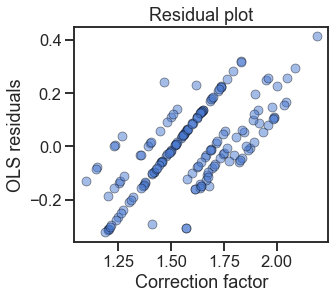

In [23]:
# Plot OLS fit and diagnostics:
fig = plt.figure(figsize=(5, 4.5))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])

# OLS residuals:
g1 = sns.scatterplot(ax=ax1, y=results.resid, x=FB_df['Inferred'], \
                     zorder=10, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g1.set_title('Residual plot')
g1.set(ylabel='OLS residuals', xlabel='Correction factor')

fig.tight_layout()

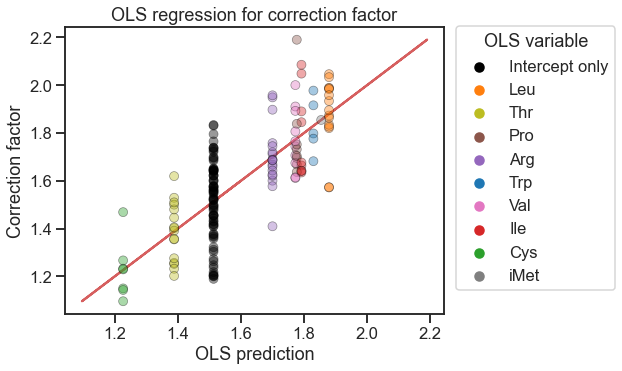

In [24]:
# Plot the regression results:
FB_df['Inferred_fitted'] = results.fittedvalues.values
aa_sele = {'Arg', 'Cys', 'Ile', 'Leu', 'Pro', 'Thr', 'Trp', 'Val', 'iMet'}
AArgb_dict = dict()
cmap_b = mpl.colormaps['tab10']
for aai, aa in enumerate(aa_sele):
    AArgb_dict[aa] = cmap_b(aai)

color_list = list()
aa_sele_list = list()
for aa in FB_df['amino_acid']:
    if aa in aa_sele:
        color_list.append(AArgb_dict[aa])
        aa_sele_list.append(aa)
    else:
        color_list.append((0,0,0,1))
        aa_sele_list.append('Intercept only')

FB_df['Variable'] = aa_sele_list
sns_palette = {aa:col for aa, col in zip(aa_sele_list, color_list)}

fig, ax1 = plt.subplots(1, 1, figsize=(9, 5.5))
g1 = sns.scatterplot(ax=ax1, data=FB_df, x='Inferred_fitted', y='Inferred', \
                     alpha=0.4, hue='Variable', \
                     edgecolor='black', linewidth=0.7, \
                     palette=sns_palette, \
                     zorder=10)
sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='OLS variable')
ax1.plot(FB_df['Inferred'].values, FB_df['Inferred'].values, \
         color='r', zorder=1)
g1.set(xlabel='OLS prediction', ylabel='Correction factor')
g1.set_title('OLS regression for correction factor')
fig.tight_layout()
fig.savefig('data/plotting_pub/correction-factor_OLS-prediction.pdf', bbox_inches='tight')

### Analyzing the prediction errors

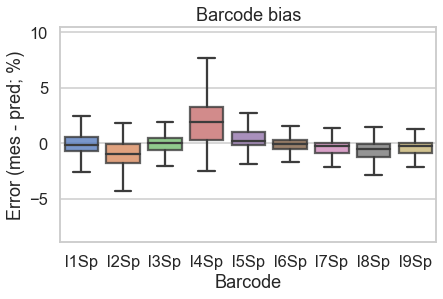

In [25]:
# Plot the prediction error for all the tRNA annotations
# broken down by barcode:
bc_order = sorted(set(titr_df['barcode']))
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))
    g1 = sns.boxplot(ax=ax1, data=titr_df, x='barcode', y='pred_err', \
                     boxprops=dict(alpha=0.8), order=bc_order, fliersize=False)

g1.set(xlabel='Barcode', ylabel='Error (mes - pred; %)')
g1.set_title('Barcode bias')
fig.tight_layout()
fig.savefig('data/plotting_pub/barcode_prediction-error.pdf', bbox_inches='tight')

# And dump the data summary as an Excel file:
titr_df.loc[:, ['barcode', 'pred_err']].pivot(columns='barcode').describe().to_csv('barcode-bias_summary.csv')

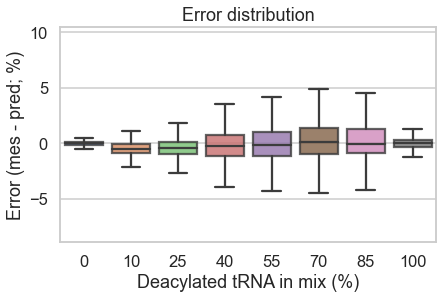

In [26]:
# Plot the prediction error for all the tRNA annotations
# broken down by the percentage :
ch_order = sorted(set(titr_df['percent_charged']))
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))
    g1 = sns.boxplot(ax=ax1, data=titr_df, x='percent_charged', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)

g1.set(xlabel='Deacylated tRNA in mix (%)', ylabel='Error (mes - pred; %)')
g1.set_title('Error distribution')
fig.tight_layout()
fig.savefig('data/plotting_pub/percent-deacyl_prediction-error.pdf', bbox_inches='tight')

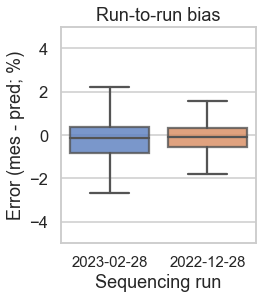

In [27]:
# Run-to-run bias:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(4, 4.5))
    g1 = sns.boxplot(ax=ax1, data=titr_df, x='run_v1', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)ß
g1.set_xticklabels(['2023-02-28', '2022-12-28'], rotation=0, size=15)
g1.set(xlabel='Sequencing run', ylabel='Error (mes - pred; %)', ylim=(-5, 5))
g1.set_title('Run-to-run bias')
fig.tight_layout()
fig.savefig('data/plotting_pub/run-to-run_prediction-error.pdf', bbox_inches='tight')